<a href="https://colab.research.google.com/github/Brunoxue/hsi_examples/blob/main/lsma_tite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A Demo on Hyperspectral Linear Spectral Mixture Analysis with Python
This demo notebook shows an example of Linear Spectral Mixture Analysis (LSMA) using MATLAB. We’ll cover: 1) Loading the hyperspectral data; 2) Estimating the number of endmembers using Noise-Whitened Harsanyi–Farrand–Chang (NWHFC); 3) Extracting endmembers using the Automatic Target Generation Process (ATGP); and 4) Performing linear unmixing using Non-negative Constrained Least Squares (NCLS) and Fully Constrained Least Squares (FCLS)

## 1. Download the Dataset from Github
Downloads the dataset by cloning the tite GitHub repository to the local environment. The dataset is stored in a folder named tite.

In [1]:
# Get dataset from Github repo
!git clone https://github.com/Brunoxue/tite.git

fatal: destination path 'tite' already exists and is not an empty directory.


## 2. Importing Required Libraries

In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, inv
from scipy.special import erfinv

## 3. Loading the Dataset
First, we can load the variables from the tite_reflectance.mat file into the Python environment.

In [3]:
# Load the hyperspectral data
data = loadmat('tite/tite_reflectance.mat')
hsi = data['TI2'].astype(float)
minerals = data['minerals'].astype(float)

## 4. Estimate Number of Endmembers with Noise-Whitened Harsanyi–Farrand–Chang (NWHFC)
Noise-Whitened Harsanyi–Farrand–Chang (NWHFC) is a method to estimate the number of endmembers in an HSI scene.

In [4]:
# Noise-Whitened Harsanyi–Farrand–Chang (NWHFC)
def NWHFC(HIM, P_fa):
    """
    Noise-Whitened Harsanyi–Farrand–Chang (NWHFC) method to estimate the number of endmembers.
    """
    x, y, L = HIM.shape
    N = x * y
    r = HIM.reshape(N, L).T

    R = np.dot(r, r.T) / N
    u = np.mean(r, axis=1, keepdims=True)
    K = R - np.dot(u, u.T)

    invK = inv(K)
    tuta = np.diag(invK)
    noiseK = 1.0 / tuta
    noiseK = np.diag(noiseK)

    r_w = np.dot(inv(sqrtm(noiseK)), r)

    R_w = np.dot(r_w, r_w.T) / N
    u_w = np.mean(r_w, axis=1, keepdims=True)
    K_w = R_w - np.dot(u_w, u_w.T)

    D1 = np.sort(np.linalg.eigvalsh(R_w))[::-1]
    D2 = np.sort(np.linalg.eigvalsh(K_w))[::-1]

    sita = np.sqrt((D1**2 + D2**2) * 2 / N)
    Threshold = (np.sqrt(2)) * sita * erfinv(1 - 2 * P_fa)

    valueVDEigen = (D1 - D2) > Threshold
    nVD = np.sum(valueVDEigen)

    return nVD

# Estimate the number of endmembers
nVD = NWHFC(hsi, 1e-4)
print(f"This HSI scene contains {nVD} endmembers.")

This HSI scene contains 5 endmembers.


## 4. Find Endmembers with Automatic Target Generation Process (ATGP)
The NWHFC estiamted nVD number is utilized as input to specific the number of endmember to be found by ATGP.

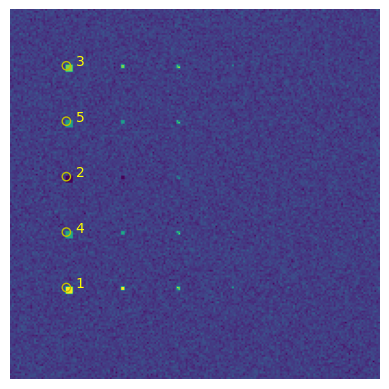

In [5]:
# Automatic Target Generation Process (ATGP)
def ATGP(HSI,p):
  '''
  HSI: Hyperspectral Image
  p: Number of targets
  '''
  (x,y,L)=HSI.shape
  N=x*y
  r=np.reshape(HSI,(N,L))

  idxTgt = [np.argmax(np.sum(r*r,axis=1))]
  spTgt = r[idxTgt,:].squeeze()

  for idx in range(1,6):
    U = spTgt.T

    if U.ndim == 1:
      P_U_per = np.eye(L)-U@U.T/(U.T@U)
    else:
      P_U_per = np.eye(L)-U@np.linalg.pinv(U.T@U)@U.T

    scoreATGP = r@P_U_per*r
    idxNewTgt = np.argmax(np.sum(scoreATGP,axis=1))

    spTgt=np.vstack((spTgt,r[idxNewTgt,:].squeeze()))
    idxTgt.append(idxNewTgt)

  posTgt = np.unravel_index(idxTgt, (x,y), order='C')

  return posTgt, spTgt.T

# Define the number of endmembers (estimated by NWHFC)
numTgt = nVD

posTgt, spTgt = ATGP(hsi,numTgt)

plt.figure()
plt.imshow(hsi[:, :, 100])
plt.axis('off')

for idx in range(numTgt):
    plt.scatter(posTgt[1][idx], posTgt[0][idx], facecolors='none', edgecolors='y')  # Plot target points
    plt.text(posTgt[1][idx] + 5, posTgt[0][idx], str(idx + 1), color='yellow')  # Label target points

plt.show()

## 6. Linear Unmixing using Non-negative Constrained Least Squares (NCLS)
Next, we use the NCLS method, with ATGP founded endmembers. Each subplot shows the abundance of endmember in the scene as computed by the NCLS method.

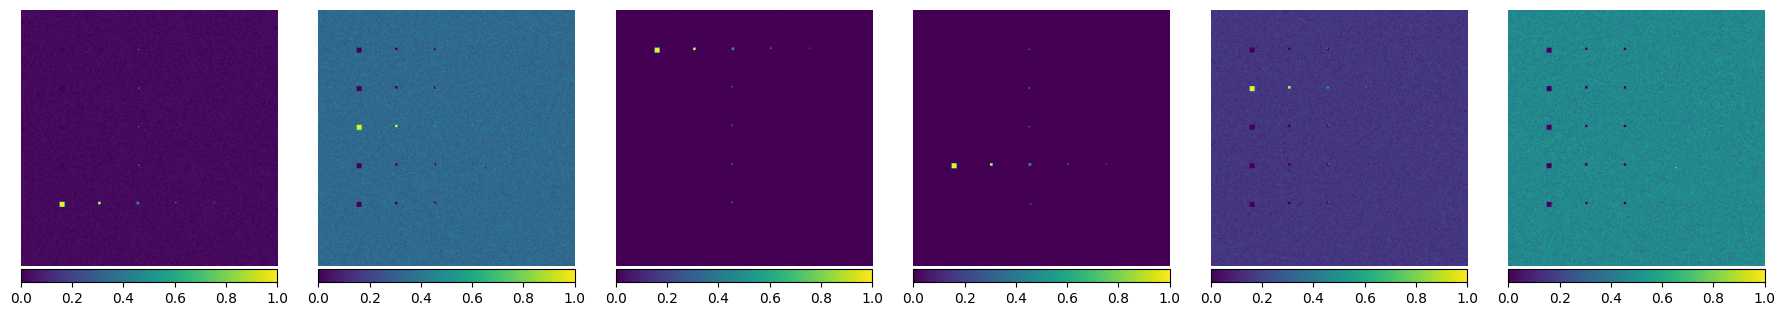

In [6]:
# Non-negative Constrained Least Squares (NCLS)
def NCLS(HSI, M):
    x, y, L = HSI.shape
    p = M.shape[1]

    N = x * y
    r = HSI.reshape(N, L).T

    from scipy.optimize import lsq_linear

    abundanceNCLS = np.zeros((N, p))
    for idx in range(N):
        result = lsq_linear(M, r[:, idx], bounds=(0, np.inf), method='bvls')
        abundanceNCLS[idx, :] = result.x

    abundanceNCLS = abundanceNCLS.reshape(x, y, p)

    return abundanceNCLS

# Compute the abundance maps
abundanceNCLS = NCLS(hsi, spTgt)

# Plot the abundance maps for NCLS
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(18, 4), subplot_kw={'xticks': [], 'yticks': []})
for idx in range(6):
    im = axs[idx].imshow(abundanceNCLS[:, :, idx], cmap='viridis')
    axs[idx].axis('off')
    fig.colorbar(im, ax=axs[idx], orientation='horizontal', pad=0.01)
plt.tight_layout()
plt.show()

## 7. Linear Unmixing using Fully Constrained Least Squares (FCLS)
Next, we use the FCLS method, with ATGP founded endmembers. FCLS adds both non-negativity and sum-to-one constraints to the unmixing problem. Each subplot represents the estimated abundance of a specific material, ensuring that the abundance follows non-negative and sum-to-one constraints.

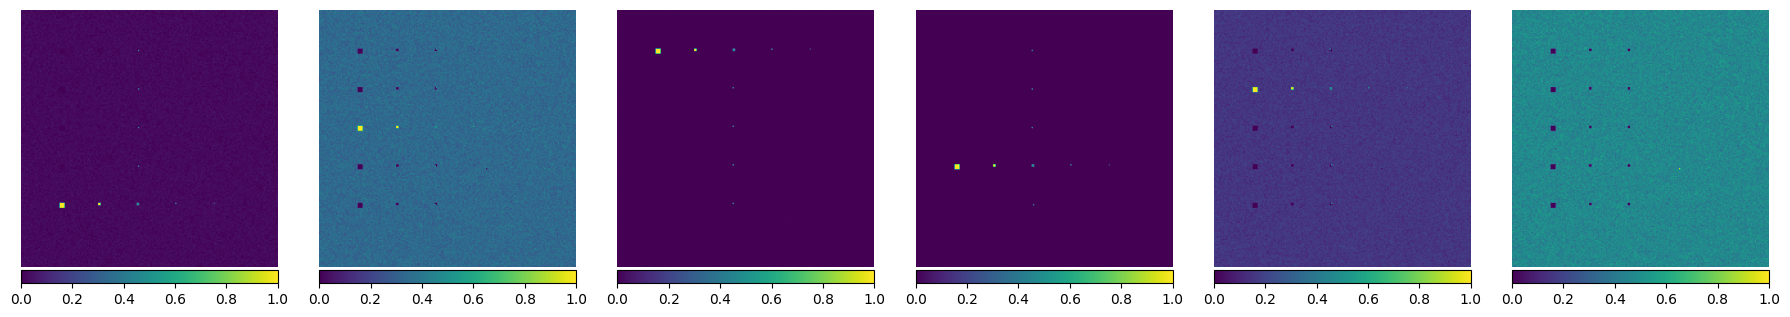

In [7]:
# Fully Constrained Least Squares (FCLS)
def FCLS(HSI, M):
    x, y, L = HSI.shape
    p = M.shape[1]
    N = x * y
    r = HSI.reshape(N, L).T

    M = np.vstack([M, np.ones((1, p))])
    r = np.vstack([r, np.ones((1, N))])

    from scipy.optimize import lsq_linear

    abundanceFCLS = np.zeros((N, p))
    for idx in range(N):
        result = lsq_linear(M, r[:, idx], bounds=(0, np.inf), method='bvls')
        abundanceFCLS[idx, :] = result.x

    abundanceFCLS = abundanceFCLS.reshape(x, y, p)

    return abundanceFCLS

# Compute the abundance maps
abundanceFCLS = FCLS(hsi, spTgt)

# Plot the abundance maps for FCLS
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(18, 4), subplot_kw={'xticks': [], 'yticks': []})
for idx in range(6):
    im = axs[idx].imshow(abundanceFCLS[:, :, idx], cmap='viridis')
    axs[idx].axis('off')
    fig.colorbar(im, ax=axs[idx], orientation='horizontal', pad=0.01)
plt.tight_layout()
plt.show()